# Imports

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import train_test_split

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Read the data

In [47]:
data = pd.read_csv('bank-full.csv', sep = ';')

In [48]:
data.shape

(45211, 17)

In [49]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [50]:
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

In [51]:
for column in data.columns:
    
    if column in categorical_columns:
        
        print(np.unique(data[column].values))
        print('\n')

['admin.' 'blue-collar' 'entrepreneur' 'housemaid' 'management' 'retired'
 'self-employed' 'services' 'student' 'technician' 'unemployed' 'unknown']


['divorced' 'married' 'single']


['primary' 'secondary' 'tertiary' 'unknown']


['no' 'yes']


['no' 'yes']


['no' 'yes']


['cellular' 'telephone' 'unknown']


['apr' 'aug' 'dec' 'feb' 'jan' 'jul' 'jun' 'mar' 'may' 'nov' 'oct' 'sep']


['failure' 'other' 'success' 'unknown']


['no' 'yes']




https://archive.ics.uci.edu/ml/datasets/Bank+Marketing?fbclid=IwAR1lVl78ldHblVgR4UZuzPxrxEID6Vuwph33nl49vPL2vLppeYuk7tizk4o

Summay of data

Categorical Variables :

[1] job: admin,technician, services, management, retired, blue-collar, unemployed, entrepreneur, housemaid, unknown, self-employed, student

[2] marital: married, single, divorced

[3] education: secondary, tertiary, primary, unknown

[4] default: has credit in default? (yes, no)

[5] housing: has housing loan? (yes, no)

[6] loan: yes, no

[7] contact: unknown, cellular, telephone

[8] month: jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec

[9] poutcome: outcome of the previous marketing campaign (unknown, other, failure, success)

[10] y: has the client subscribed a term deposit? (yes, no) - dependent variable


Numerical Variables:

[1] age

[2] balance

[3] day

[4] duration: last contact duration, in seconds (numeric)

[5] campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

[6] pdays: number of days that passed by after the client was last contacted from a previous campaign 

[7] previous: number of contacts performed before this campaign and for this client

The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y)

# EDA

In [52]:
data[data.isnull().any(axis = 1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

# Numeric variables

In [53]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


Age

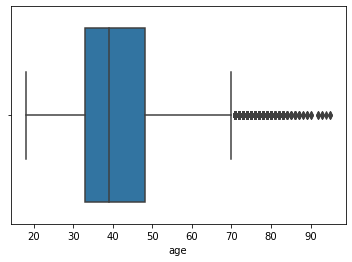

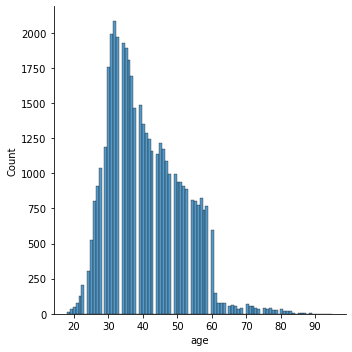

In [54]:
sns.boxplot(x = data['age'])
sns.displot(x = data['age'])

Balance

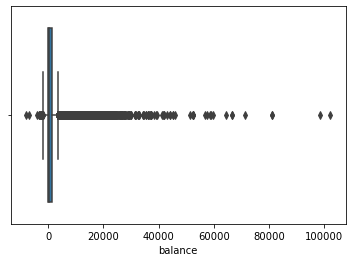

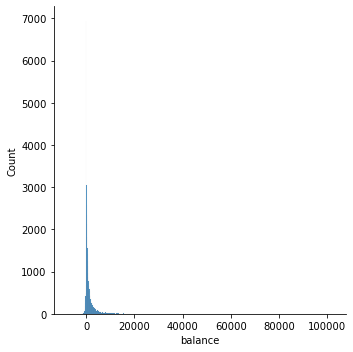

In [55]:
sns.boxplot(x = data['balance'])
sns.displot(x = data['balance'])

Day

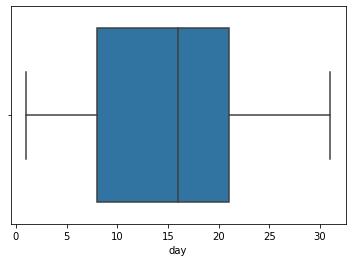

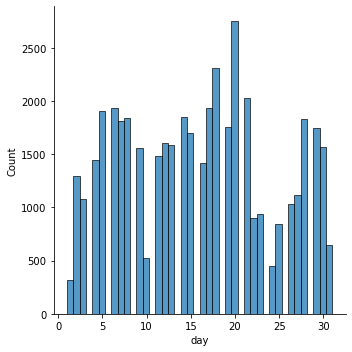

In [56]:
sns.boxplot(x = data['day'])
sns.displot(x = data['day'])

Duration

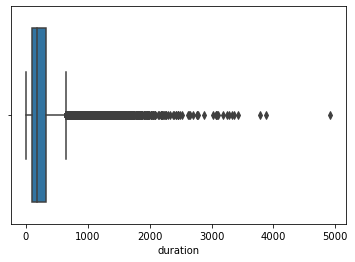

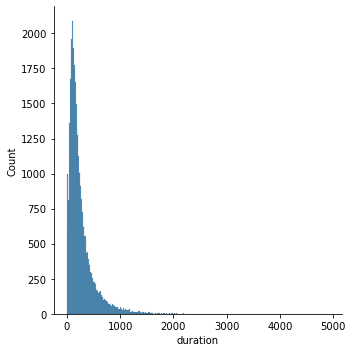

In [57]:
sns.boxplot(x = data['duration'])
sns.displot(x = data['duration'])

Campaign

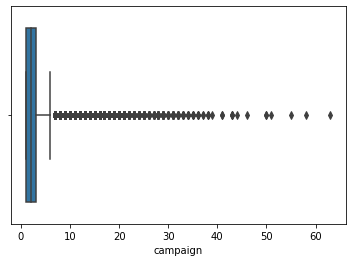

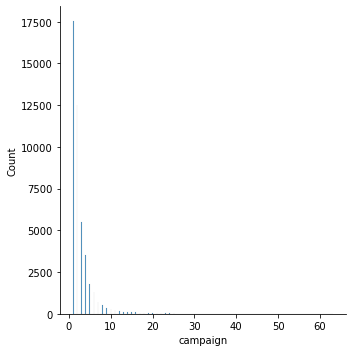

In [58]:
sns.boxplot(x = data['campaign'])
sns.displot(x = data['campaign'])

Pdays

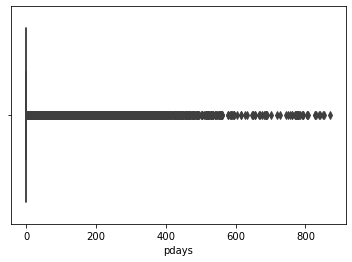

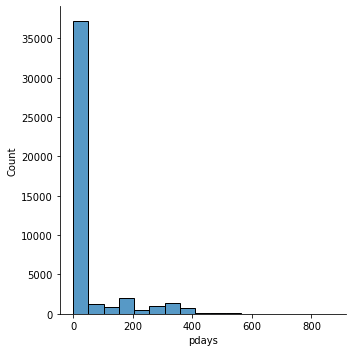

In [59]:
sns.boxplot(x = data['pdays'])
sns.displot(x = data['pdays'])

Previous

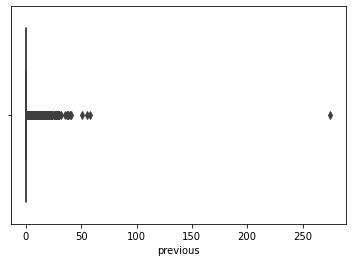

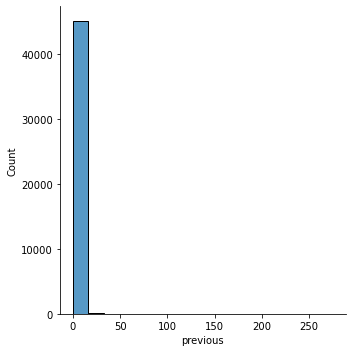

In [60]:
sns.boxplot(x = data['previous'])
sns.displot(x = data['previous'])

Scatterplot showing age and balance

<AxesSubplot:xlabel='age', ylabel='balance'>

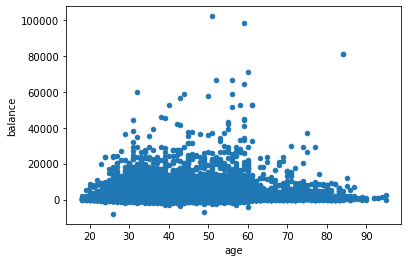

In [61]:
data.plot(kind = 'scatter', x = 'age', y = 'balance')

...

# Categorical variables

Explore people who made a deposit vs. job category

In [62]:
jobs = ['management', 'blue-collar', 'technician', 'admin.', 'services', 'retired', 'self-employed', 'student',
        'unemployed', 'entrepreneur', 'housemaid', 'unknown']

In [63]:
for j in jobs:
    print('{:15} : {:5}'. format(j, len(data[(data.y == 'yes') & (data.job == j)])))

management      :  1301
blue-collar     :   708
technician      :   840
admin.          :   631
services        :   369
retired         :   516
self-employed   :   187
student         :   269
unemployed      :   202
entrepreneur    :   123
housemaid       :   109
unknown         :    34


Different types of job categories and their counts

In [64]:
data.job.value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

Target class balance

In [65]:
data.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

# Change dataset structure

In [66]:
data.drop('contact', axis = 1, inplace = True)
data.drop('day', axis = 1, inplace = True)
data.drop('month', axis = 1, inplace = True)

In [67]:
data.shape

(45211, 14)

In [68]:
data['default_cat'] = data['default'].map({'yes': 1, 'no': 0})
data.drop('default', axis = 1, inplace = True)

In [69]:
data['housing_cat'] = data['housing'].map({'yes': 1, 'no': 0})
data.drop('housing', axis = 1, inplace = True)

In [70]:
data['loan_cat'] = data['loan'].map({'yes': 1, 'no': 0})
data.drop('loan', axis = 1, inplace = True)

In [71]:
data['y_cat'] = data['y'].map({'yes': 1, 'no': 0})
data.drop('y', axis = 1, inplace = True)

In [72]:
data['age_quantile'] = pd.qcut(data['age'], 4, labels=["young", "middle", "floareavarstei", "old"])
data['balance_quantile'] = pd.qcut(data['balance'], 4, labels=["poor", "middle", "rich", "veryrich"])
data['duration_quantile'] = pd.qcut(data['duration'], 4, labels=["short", "medium", "long", "verylong"])

In [73]:
data.drop('age', axis = 1, inplace = True)
data.drop('balance', axis = 1, inplace = True)
data.drop('duration', axis = 1, inplace = True)
data.drop('campaign', axis = 1, inplace = True)
data.drop('previous', axis = 1, inplace = True)
data.drop('pdays', axis = 1, inplace = True)

In [74]:
data_with_dummies = pd.get_dummies(data = data, columns = ['age_quantile', 'balance_quantile', 'duration_quantile', 'job', 'marital', 'education', 'poutcome'],
                                   prefix = ['age', 'balance', 'duration', 'job', 'marital', 'education', 'poutcome'])

In [75]:
data_with_dummies.columns

Index(['default_cat', 'housing_cat', 'loan_cat', 'y_cat', 'age_young',
       'age_middle', 'age_floareavarstei', 'age_old', 'balance_poor',
       'balance_middle', 'balance_rich', 'balance_veryrich', 'duration_short',
       'duration_medium', 'duration_long', 'duration_verylong', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown'],
      dtype='object')

In [76]:
data_with_dummies.head()

,default_cat,housing_cat,loan_cat,y_cat,age_young,age_middle,age_floareavarstei,age_old,balance_poor,balance_middle,...,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,0,1,0,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
1,0,1,0,0,0,0,1,0,1,0,...,0,1,0,1,0,0,0,0,0,1
2,0,1,1,0,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,0,0,0,1
4,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1


# Saving a raw subset of the data

In [77]:
data_raw = data_with_dummies.sample(frac = 0.1, replace = False, random_state = 15)
X_raw = data_raw.loc[:, data_raw.columns != 'y_cat']
y_raw = data_raw.loc[:, 'y_cat']
data_new = pd.concat([data_with_dummies, data_raw]).drop_duplicates(keep=False)

# Tweaking data imbalance

In [78]:
sum_no=0
sum_yes=0
for i, row in data_new.iterrows():
    if(row[9] == 1): sum_yes += 1
    else: sum_no += 1
print('sum_yes: {}, sum_no: {}, quotient: {}'.format(sum_yes,sum_no, sum_yes/sum_no))

sum_yes: 2200, sum_no: 6761, quotient: 0.32539565153083866


## Upsampling

In [79]:
data_majority=data_new[data_new.y_cat==0]
data_minority=data_new[data_new.y_cat==1]
data_minority_upsampled=resample(data_minority, replace=True, n_samples=31925)
data_up=pd.concat([data_majority, data_minority_upsampled])

## Downsampling

In [80]:
data_majority_downsampled=resample(data_majority, replace=False, n_samples=4243)
data_down=pd.concat([data_minority, data_majority_downsampled])

# Main

## Correlation

In [81]:
corr = data_new.corr()

Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

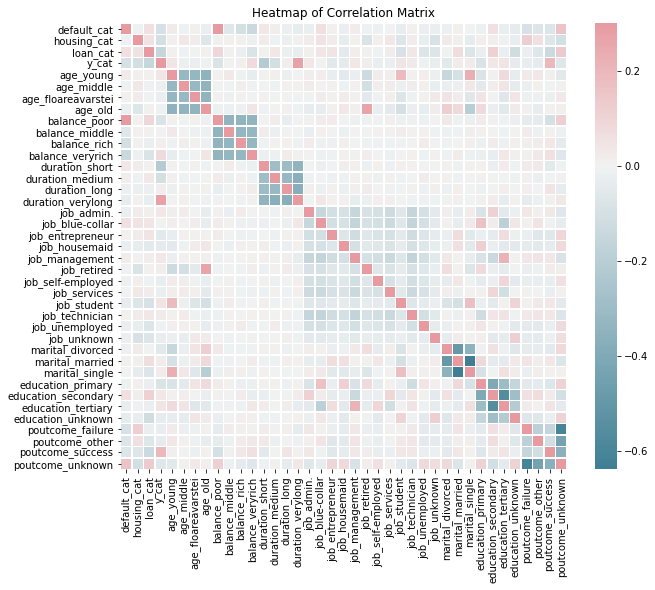

In [82]:
plt.figure(figsize = (10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, cmap = cmap, vmax = .3, center = 0, 
            square = True, linewidths = .5, cbar_kws = {'shrink': .82})

plt.title('Heatmap of Correlation Matrix')

## Train/test split

In [153]:
X = data_new.drop('y_cat', 1)
y = data_new.y_cat
#X = data_up.drop('y_cat', 1)
#y = data_up.y_cat
#X = data_down.drop('y_cat', 1)
#y = data_down.y_cat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

## Modelling

# Decision Tree

In [154]:
dt = BayesSearchCV(
   DecisionTreeClassifier(),
    {
        'criterion': Categorical(['entropy', 'gini']),
        'max_depth': Integer(4, 100),
        'min_samples_leaf': Integer(1, 500),
        'max_features': Integer(10, 32),
    },
    n_iter = 30
)
_ = dt.fit(X_train, y_train)

In [155]:
dt.score(X_train, y_train)

0.7833426339285714

In [156]:
dt.score(X_test, y_test)

0.7752370329057445

### Testing on raw data

In [157]:
y_pred = dt.predict(X_raw)
cm = confusion_matrix(y_raw, y_pred)
print(cm)
dt.score(X_raw, y_raw)

[[3982   26]
 [ 442   71]]


0.8964830789648308

In [158]:
dt.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator__ccp_alpha': 0.0,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__presort': 'deprecated',
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeClassifier(),
 'fit_params': None,
 'iid': True,
 'n_iter': 30,
 'n_jobs': 1,
 'n_points': 1,
 'optimizer_kwargs': None,
 'pre_dispatch': '2*n_jobs',
 'random_state': None,
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'search_spaces': {'criterion': Categorical(categories=('entropy', 'gini'), prior=None),
  'max_depth': Integer(low=4, high=100, prior='uniform', transform='identity'),
  'min_samples_leaf': Integer(l

### Pruning to avoid overfitting and visualizing the tree

In [159]:
dtplot = DecisionTreeClassifier(criterion = 'gini', min_samples_leaf = 100)
dtplot.fit(X_train, y_train)
dot_data = tree.export_graphviz(dtplot, out_file = "tree.dot",
                                filled = True)
graph = graphviz.Source(dot_data, format = "png")
!dot -Tpng tree.dot -o tree6.png

In [160]:
y_pred = dtplot.predict(X_raw)
cm = confusion_matrix(y_raw, y_pred)
print(cm)
dtplot.score(X_raw, y_raw)

[[3690  318]
 [ 308  205]]


0.8615350586153506